# Figure 6

Notebook for plots for figure 6

Taylor diagrams display the performance of published gap-filling techniques andLDEO-HPD product.  Performance is evaluated at two timeseries:  
- A) HOT and 
- B) BATS; andtwo global datasets:  
- C) LDEO and 
- D) GLODAP. Red star indicates standard deviation of eachdataset.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}

import xarray as xr
import numpy as np
import pandas as pd
import cmocean.cm as cm
import matplotlib 
import glob

#import modin.pandas as pdm
import os
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import skill_metrics as sm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot
from plotting_tools.taylor_diagram import TaylorDiagram
from plotting_tools.target_diagram import TargetDiagram
from stats_tools.target_diagram import target_axes

In [2]:
#dir_raw = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/raw'
#dir_clean = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/clean'
dir_figs = '/home/gloege/projects/ldeo_hpd/reports/figures'
#dir_figs = '/local/data/artemis/workspace/gloege/figures/ldeo_hpd'
dir_tests = '/local/data/artemis/workspace/gloege/data/test_sets'
dir_model = '/local/data/artemis/workspace/gloege/LDEO-FFN/data/HPD_output/XGB'
dir_prods = '/local/data/artemis/observations/pCO2_products/originals'

In [3]:
#ds = xr.open_dataset('/local/data/artemis/workspace/gloege/gregor/IPCC-AR6_FCO2_DataProducts_filled_20201118.nc')
#ds['lon'] = [lon if lon>0 else lon+360 for lon in ds['lon'].values]

## Load test set

In [3]:
ds_glodap = xr.open_dataset(f'{dir_tests}/GLODAP_1x1_198201-201812.nc').load()
ds_ldeo = xr.open_dataset(f'{dir_tests}/LDEO_1x1_198201-201812.nc')

## Load products

In [5]:
#fl_hpd='/local/data/artemis/workspace/gloege/for_amanda/LDEO_HPD_product/LDEO-HPD_mon_1x1_198201-201612.nc'
#ds_hpd = xr.open_dataset(fl_hpd)

In [4]:
fl_prod='/local/data/artemis/workspace/gloege/gregor/pco2_products_standardised.nc'
ds_prod = xr.open_dataset(fl_prod)
ds_prod['lon'] = [lon if lon>0 else lon+360 for lon in ds_prod['lon'].values]
ds_prod['time'] = pd.date_range(
    start=f'1985-01-01T00:00:00.000000000', 
    end=f'2018-12-01T00:00:00.000000000',
    freq='MS') + np.timedelta64(14, 'D')
ds_prod = ds_prod.sortby('lon')

## Load HPD

In [5]:
%%time
ds_hpd = xr.open_dataset('/local/data/artemis/workspace/gloege/ldeo-hpd/LDEO-HPD_v20210425_1x1_198201-201812.nc').mean('model')

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 3.11 s, sys: 5.26 s, total: 8.37 s
Wall time: 8.39 s


## Load data

In [6]:
# time series 
dir_data = '/local/data/artemis/workspace/gloege'

# BATS
ds_bats = xr.open_dataset(f'{dir_data}/data/BATS/BATS.nc')

# HOT
ds_hot = xr.open_dataset(f'{dir_data}/data/HOT/HOT.nc')
ds_hot = ds_hot.where(ds_hot['spco2']>0)

# locations
BATS={'lat':31.83,
      'lon':360-(64.17)}

HOTS={'lat':22.75,
      'lon':360-158}


# Load HOT
ds_hot_mon = ds_hot.resample(time='1M').mean()
ds_hot_mon = ds_hot_mon.assign_coords(lon=(202.5),
                                      lat=(22.5)).expand_dims(['lat','lon'])
ds_hot_mon = ds_hot_mon.transpose('time','lat','lon')

### ================================================
### force time vector to be proper format and range
### ================================================
dates = pd.date_range(start='1988-10-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',
                      freq='MS')+ np.timedelta64(14, 'D')
da_dates = xr.DataArray(dates, dims='time')
ds_hot_mon['time'] = dates
ds_hot_mon = ds_hot_mon.squeeze()

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
# locations
BATS={'lat':31.83,
      'lon':360-(64.17)}

HOTS={'lat':22.75,
      'lon':360-158}


In [8]:
df_hot = pd.read_csv('https://hahana.soest.hawaii.edu/hot/products/HOT_surface_CO2.txt',delim_whitespace=True, skiprows=7)
mask=(df_hot['pCO2calc_insitu']>0)
df_hot = df_hot[mask]
df_hot = df_hot[['date','pCO2calc_insitu']].dropna()

df_hot['time'] = pd.to_datetime(df_hot['date'])
df_hot = df_hot.rename(columns={'pCO2calc_insitu':'spco2'})

In [9]:
df_hot = df_hot[['time','spco2']].set_index('time').resample('1M').mean()

In [10]:
# load BATS
dir_data = '/local/data/artemis/workspace/gloege'
ds_bats = xr.open_dataset(f'/local/data/artemis/workspace/gloege/data/BATS/BATS.nc')


In [11]:
df_bats = ds_bats['spco2'].resample(time='1M').mean().to_dataframe()

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Target diagram

## LDEO

In [12]:
ldeo = ds_ldeo['spco2_mean'].load()
ldeo = ldeo.where(ldeo>200)
ldeo = ldeo.where(ldeo<500)

(data_somffn, data_carbo, data_lsce, data_csir, data_hpd, data_obs) = xr.align(
    ds_prod['mpisomffn'],
    ds_prod['jenamls'],
    ds_prod['lsceffnn2'],
    ds_prod['csirml6'],
    ds_hpd['spco2'],
    ldeo,)

data = {'somffn': list(data_somffn.values.flatten()), 
        'carbo': list(data_carbo.values.flatten()), 
        'lsce': list(data_lsce.values.flatten()), 
        'csir': list(data_csir.values.flatten()), 
        'hpd': list(data_hpd.values.flatten()),
        'OBS': list(data_obs.values.flatten())}

## Dataframe
df = pd.DataFrame(data)
df = df.dropna()

obs='OBS'
stats_somffn = sm.taylor_statistics(df['somffn'].values,df[obs].values,'data')
stats_lsce = sm.taylor_statistics(df['lsce'].values,df[obs].values,'data')
stats_carbo = sm.taylor_statistics(df['carbo'].values,df[obs].values,'data') # was added
stats_csir = sm.taylor_statistics(df['csir'].values,df[obs].values,'data') # was added
stats_hpd = sm.taylor_statistics(df['hpd'].values,df[obs].values,'data') # was added

# Reference std
stdref = stats_somffn['sdev'][0]

# Samples std,rho,name
samples = [
    [stats_somffn['sdev'][1], stats_somffn['ccoef'][1], "SOM-FFN",'k','o'],
    [stats_lsce['sdev'][1], stats_lsce['ccoef'][1], "FFNN-LSCE",'g','o'],
    [stats_carbo['sdev'][1], stats_carbo['ccoef'][1], "JenaMLS",'c','o'],
    [stats_csir['sdev'][1], stats_csir['ccoef'][1], "CSIRML6",'r','o'],
    [stats_hpd['sdev'][1], stats_hpd['ccoef'][1], "LDEO-HPD",'b','o'],]


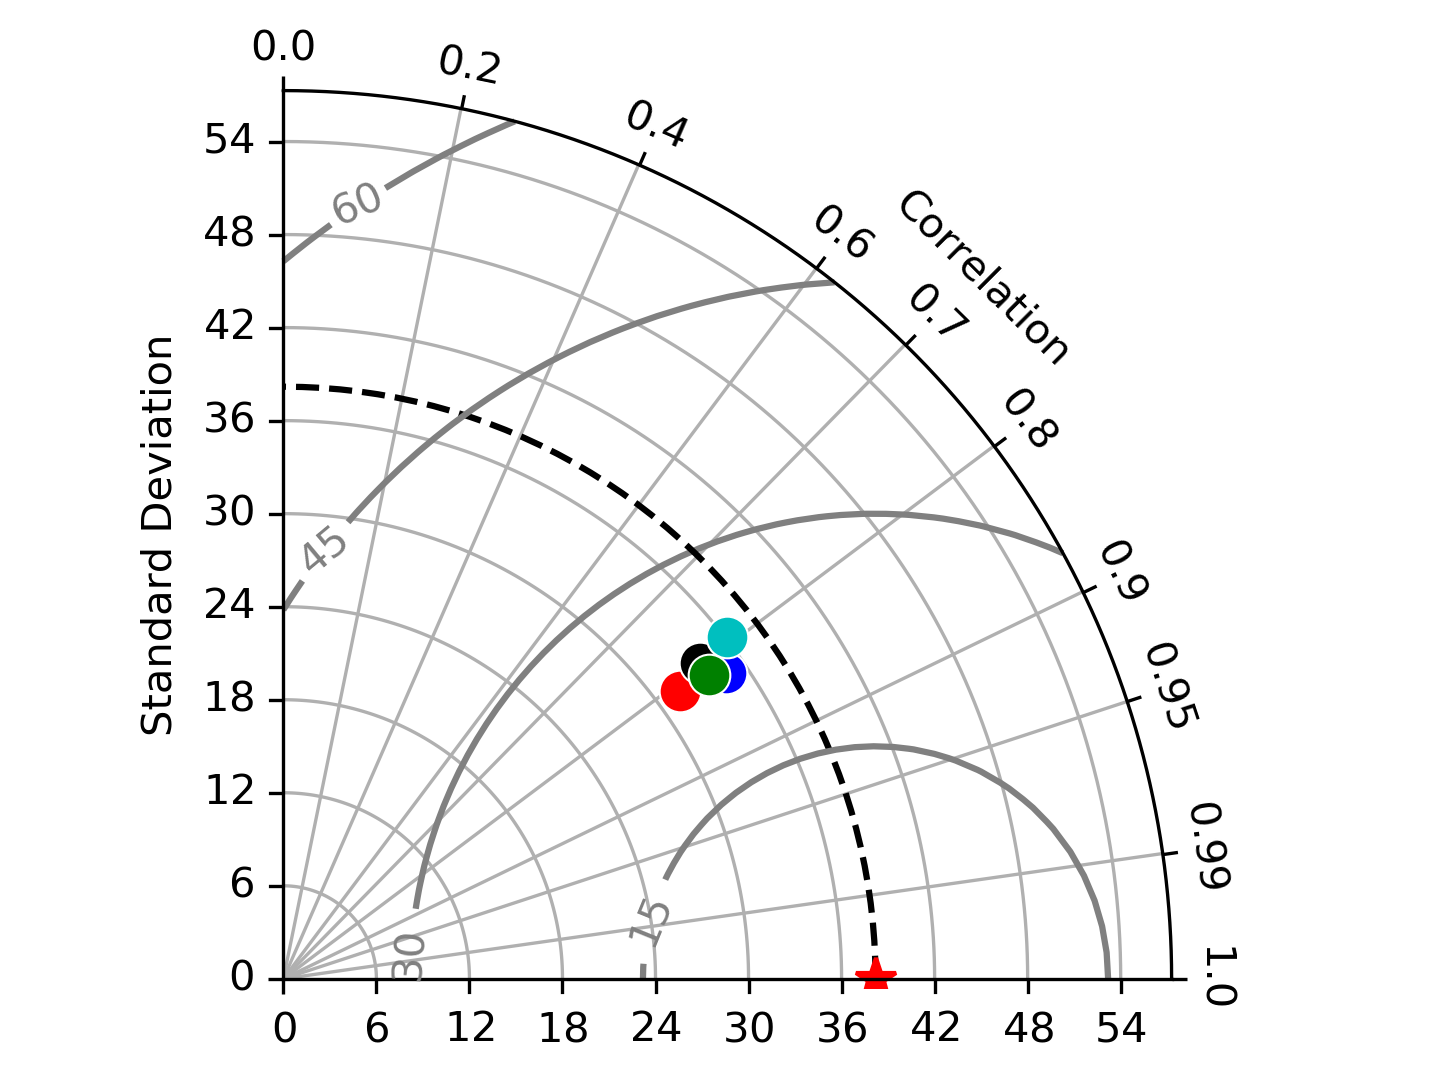

In [13]:
fig = plt.figure()

dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=False)
dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

# Remove bottom label
dia._ax.axis["left"].label.set_text("")

# Add label to left
dia._ax.axis["right"].toggle(label=True)
dia._ax.axis["right"].label.set_text("Standard Deviation")

# Add models to Taylor diagram
for i, (stddev, corrcoef, name, col, marker) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker=marker, ms=10, ls='',
                   mfc=col, mec='white', mew=0.5,
                   label=name)

# Add RMS contours, and label them
contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
plt.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

dia.add_grid()                                  # Add grid
dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

#plt.savefig(f'{dir_figs}/taylor_diagram_ldeo_latest.pdf', 
#                transparent = True, 
#                bbox_inches = 'tight', 
#                pad_inches = 0)

In [26]:
for prod in df.columns:
    print(prod)
    print(df[prod].mean()-df['OBS'].mean())

somffn
-1.9817446908598981
carbo
-2.2868244962348854
lsce
-1.54154909671837
csir
-2.325142887637355
hpd
-1.8134577039476198
OBS
0.0


In [27]:
def rmse(prod):
    return np.sqrt(((df[prod]-df['OBS'])**2).mean())

for prod in df.columns:
    print(prod)
    print(rmse(prod))

somffn
23.4254303273991
carbo
24.12448080980412
lsce
22.424807678294503
csir
22.54082748785816
hpd
22.026050777685033
OBS
0.0


## GLODAP

In [14]:
ds_glodap = ds_glodap.where(ds_glodap>275)
ds_glodap = ds_glodap.where(ds_glodap<500)

In [15]:
%%time
(data_somffn, data_carbo, data_lsce, data_csir, data_hpd, data_obs) = xr.align(
    ds_prod['mpisomffn'],
    ds_prod['jenamls'],
    ds_prod['lsceffnn2'],
    ds_prod['csirml6'],
    ds_hpd['spco2'],
    ds_glodap['spco2_mean'],)

data = {'somffn': list(data_somffn.values.flatten()), 
        'carbo': list(data_carbo.values.flatten()), 
        'lsce': list(data_lsce.values.flatten()), 
        'csir': list(data_csir.values.flatten()), 
        'hpd': list(data_hpd.values.flatten()), 
        'OBS': list(data_obs.values.flatten())}

## Dataframe
df = pd.DataFrame(data)
df = df.dropna()

obs='OBS'
stats_somffn = sm.taylor_statistics(df['somffn'].values,df[obs].values,'data')
stats_lsce = sm.taylor_statistics(df['lsce'].values,df[obs].values,'data')
stats_carbo = sm.taylor_statistics(df['carbo'].values,df[obs].values,'data') # was added
stats_csir = sm.taylor_statistics(df['csir'].values,df[obs].values,'data') # was added
stats_hpd = sm.taylor_statistics(df['hpd'].values,df[obs].values,'data') # was added

# Reference std
stdref = stats_somffn['sdev'][0]

# Samples std,rho,name
samples = [
    [stats_somffn['sdev'][1], stats_somffn['ccoef'][1], "SOM-FFN",'k','o'],
    [stats_lsce['sdev'][1], stats_lsce['ccoef'][1], "FFNN-LSCE",'g','o'],
    [stats_carbo['sdev'][1], stats_carbo['ccoef'][1], "JenaMLS",'c','o'],
    [stats_csir['sdev'][1], stats_csir['ccoef'][1], "CSIRML6",'r','o'],
    [stats_hpd['sdev'][1], stats_hpd['ccoef'][1], "GLODAP",'b','o'],]

CPU times: user 25.6 s, sys: 10.9 s, total: 36.5 s
Wall time: 36.5 s


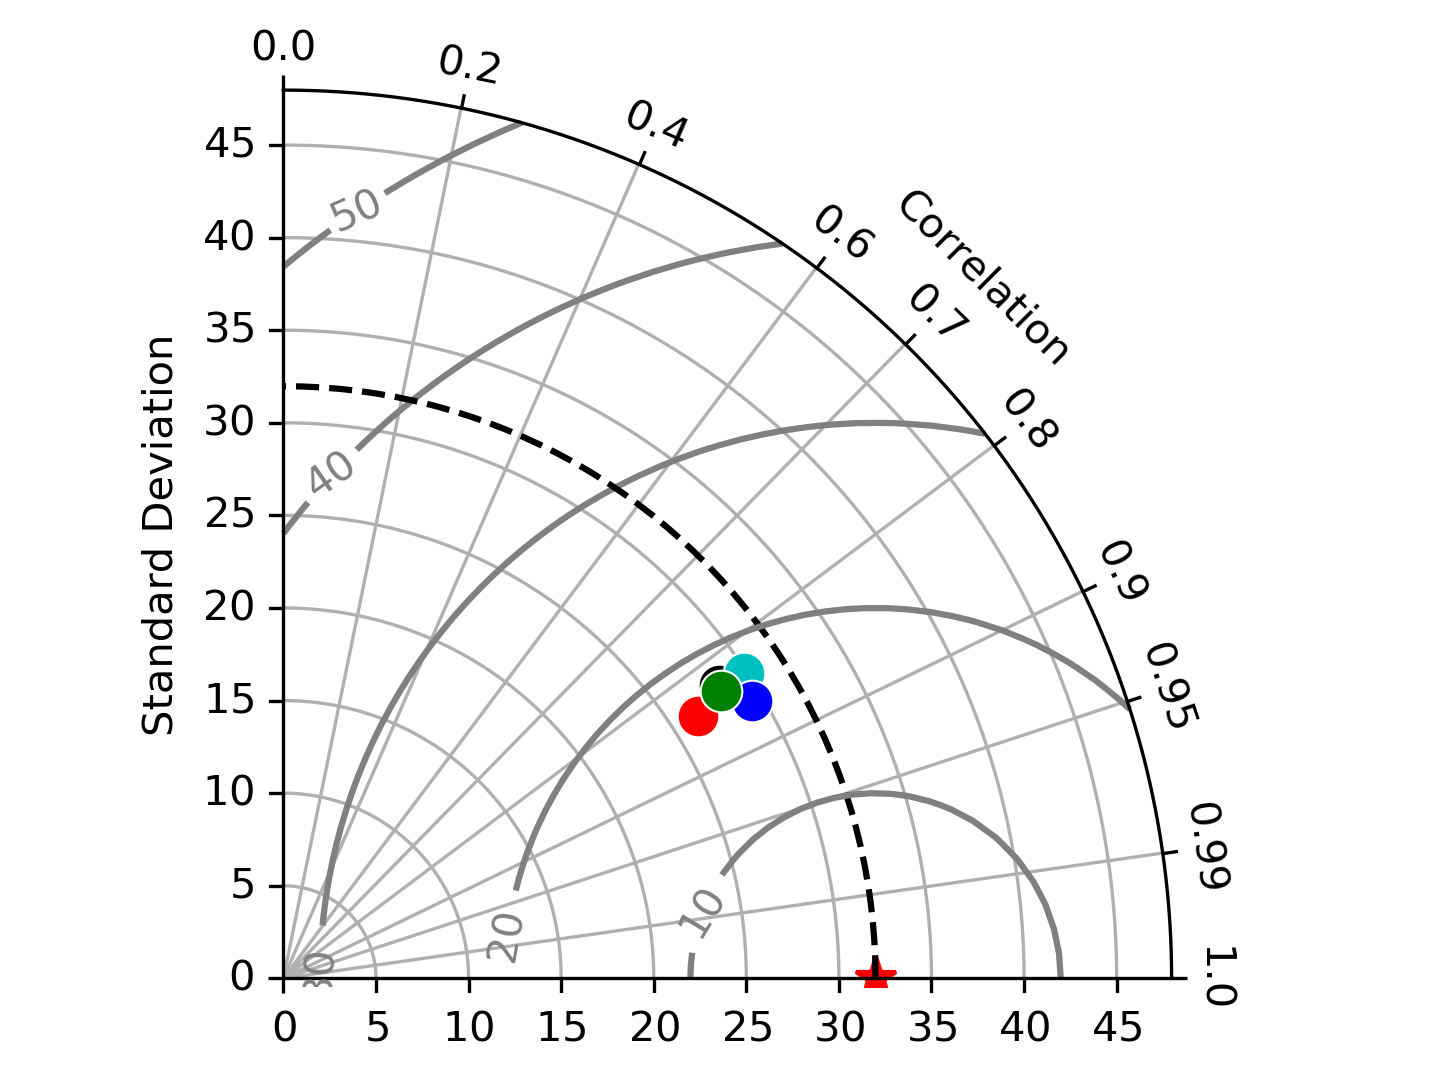

In [16]:
fig = plt.figure()

dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=False)
dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

# Remove bottom label
dia._ax.axis["left"].label.set_text("")

# Add label to left
dia._ax.axis["right"].toggle(label=True)
dia._ax.axis["right"].label.set_text("Standard Deviation")

# Add models to Taylor diagram
for i, (stddev, corrcoef, name, col, marker) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker=marker, ms=10, ls='',
                   mfc=col, mec='white', mew=0.5,
                   label=name)

# Add RMS contours, and label them
contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
plt.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

dia.add_grid()                                  # Add grid
dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

#plt.savefig(f'{dir_figs}/taylor_diagram_glodap_latest.pdf', 
#                transparent = True, 
#                bbox_inches = 'tight', 
#                pad_inches = 0)

In [32]:
for prod in df.columns:
    print(prod)
    print(df[prod].mean()-df['OBS'].mean())

somffn
1.8774538033503063
carbo
2.5251432657948953
lsce
2.4456949193681794
csir
1.3644537406615314
hpd
2.3659498110508252
OBS
0.0


In [33]:
def rmse(prod):
    return np.sqrt(((df[prod]-df['OBS'])**2).mean())

for prod in df.columns:
    print(prod)
    print(rmse(prod))

somffn
18.052697694309856
carbo
18.151990421606445
lsce
17.789991205116593
csir
17.160287873997028
hpd
16.56412875169553
OBS
0.0


# HOT time series

In [36]:
ds_prod_hot = ds_prod.sel(
    lat=HOTS['lat'], 
    lon=HOTS['lon'], 
    method='nearest')

ds_hpd_hot = ds_hpd.sel(
    lat=HOTS['lat'], 
    lon=HOTS['lon'], 
    method='nearest')

In [48]:
(data_somffn, data_carbo, data_lsce, data_csir, data_hpd, data_obs) = xr.align(
    ds_prod_hot['mpisomffn'],
    ds_prod_hot['jenamls'],
    ds_prod_hot['lsceffnn2'],
    ds_prod_hot['csirml6'],
    ds_hpd_hot['spco2'],
    ds_hot_mon['spco2'].load())

data = {'somffn': list(data_somffn.values.flatten()), 
        'carbo': list(data_carbo.values.flatten()), 
        'lsce': list(data_lsce.values.flatten()), 
        'csir': list(data_csir.values.flatten()), 
        'hpd': list(data_hpd.values.flatten()), 
        'OBS': list(data_obs.values.flatten())}

## Dataframe
df = pd.DataFrame(data)
df = df.dropna()

obs='OBS'
stats_somffn = sm.taylor_statistics(df['somffn'].values,df[obs].values,'data')
stats_lsce = sm.taylor_statistics(df['lsce'].values,df[obs].values,'data')
stats_carbo = sm.taylor_statistics(df['carbo'].values,df[obs].values,'data') # was added
stats_csir = sm.taylor_statistics(df['csir'].values,df[obs].values,'data') # was added
stats_hpd = sm.taylor_statistics(df['hpd'].values,df[obs].values,'data') # was added

# Reference std
stdref = stats_somffn['sdev'][0]

# Samples std,rho,name
samples = [
    [stats_somffn['sdev'][1], stats_somffn['ccoef'][1], "SOM-FFN",'k','o'],
    [stats_lsce['sdev'][1], stats_lsce['ccoef'][1], "FFNN-LSCE",'g','o'],
    [stats_carbo['sdev'][1], stats_carbo['ccoef'][1], "JenaMLS",'c','o'],
    [stats_csir['sdev'][1], stats_csir['ccoef'][1], "CSIRML6",'r','o'],
    [stats_hpd['sdev'][1], stats_hpd['ccoef'][1], "GLODAP",'b','o'],]


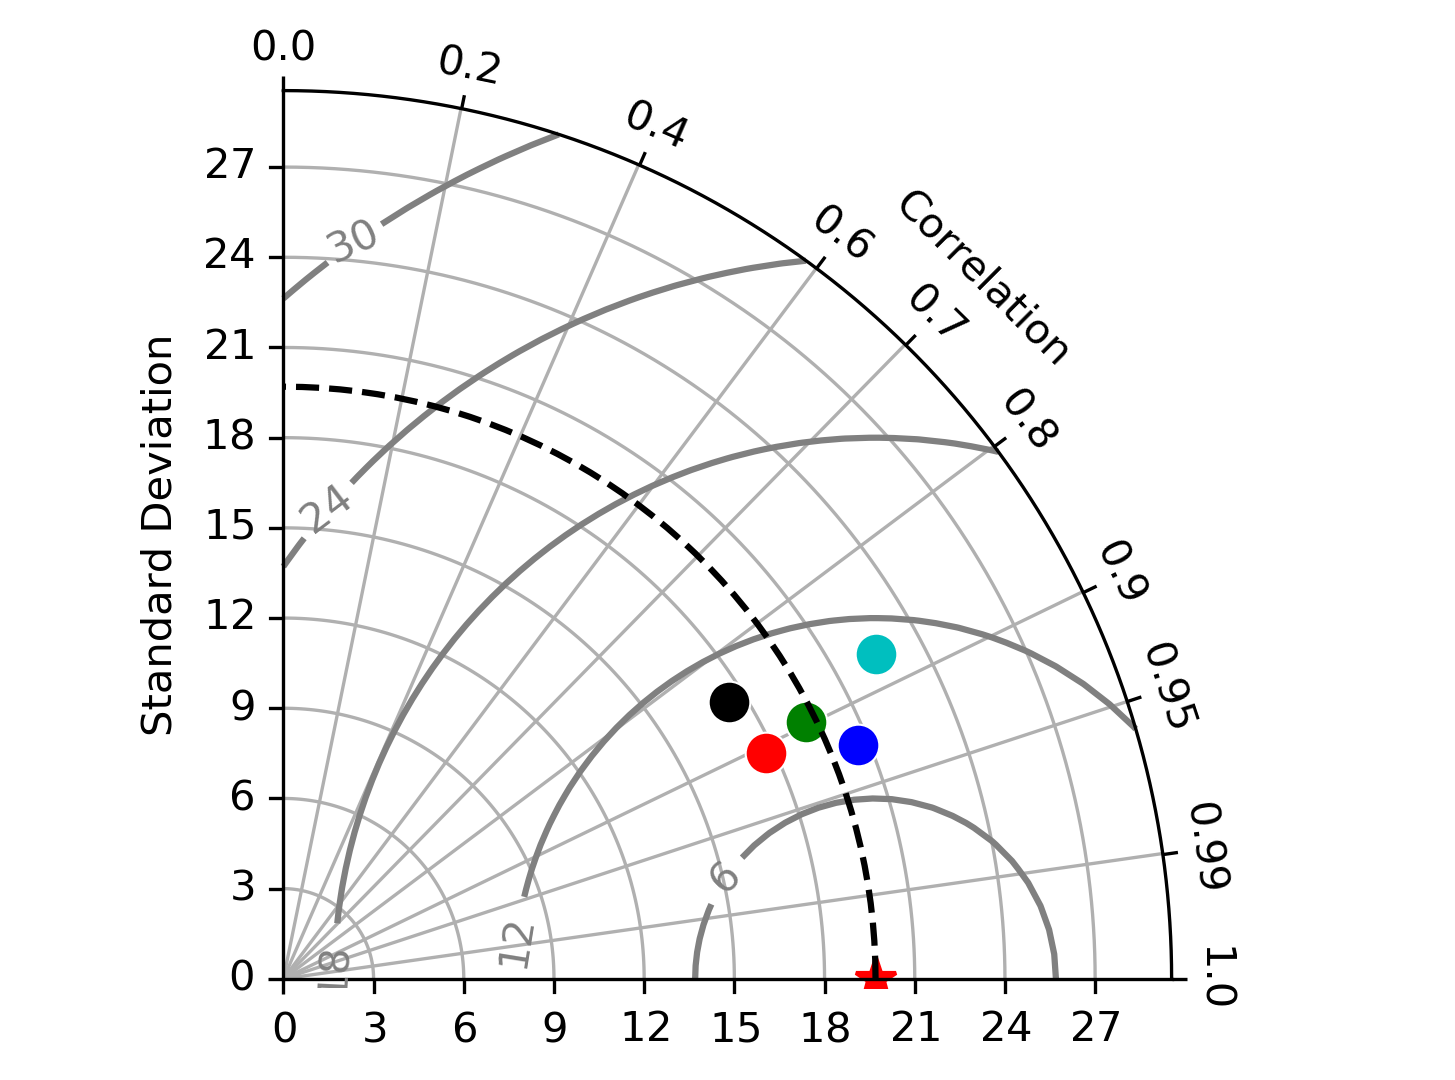

In [49]:

fig = plt.figure()

dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=False)
dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

# Remove bottom label
dia._ax.axis["left"].label.set_text("")

# Add label to left
dia._ax.axis["right"].toggle(label=True)
dia._ax.axis["right"].label.set_text("Standard Deviation")

# Add models to Taylor diagram
for i, (stddev, corrcoef, name, col, marker) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker=marker, ms=10, ls='',
                   mfc=col, mec='white', mew=0.5,
                   label=name)

# Add RMS contours, and label them
contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
plt.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

dia.add_grid()                                  # Add grid
dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward


plt.savefig(f'{dir_figs}/taylor_diagram_hot_latest.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)

In [50]:
for prod in df.columns:
    print(prod)
    print(df[prod].mean()-df['OBS'].mean())

somffn
1.0608005727314094
carbo
3.4979268681536837
lsce
3.4191649087384235
csir
2.063221554131246
hpd
4.200778471997694
OBS
0.0


In [51]:
def rmse(prod):
    return np.sqrt(((df[prod]-df['OBS'])**2).mean())

for prod in df.columns:
    print(prod)
    print(rmse(prod))

somffn
10.477705226134798
carbo
11.348990774301537
lsce
9.493809499297523
csir
8.600407819337383
hpd
8.867001791820668
OBS
0.0


# BATS

In [52]:
ds_bats_mon = ds_bats.resample(time='1M').mean()


ds_bats_mon = ds_bats_mon.assign_coords(lon=(295.5),
                                       lat=(31.5)).expand_dims(['lat','lon'])
ds_bats_mon = ds_bats_mon.transpose('time','lat','lon')


### ================================================
### force time vector to be proper format and range
### ================================================
dates = pd.date_range(start='1983-09-01T00:00:00.000000000', 
                      end='2018-08-01T00:00:00.000000000',
                      freq='MS')+ np.timedelta64(14, 'D')
da_dates = xr.DataArray(dates, dims='time')
ds_bats_mon['time'] = dates
ds_bats_mon = ds_bats_mon.squeeze()


/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [53]:
ds_prod_bats = ds_prod.sel(
    lat=BATS['lat'], 
    lon=BATS['lon'], 
    method='nearest')

ds_hpd_bats = ds_hpd.sel(
    lat=BATS['lat'], 
    lon=BATS['lon'], 
    method='nearest')

In [54]:
(data_somffn, data_carbo, data_lsce, data_csir, data_hpd, data_obs) = xr.align(
    ds_prod_bats['mpisomffn'],
    ds_prod_bats['jenamls'],
    ds_prod_bats['lsceffnn2'],
    ds_prod_bats['csirml6'],
    ds_hpd_bats['spco2'],
    ds_bats_mon['spco2'].load(),)

data = {'somffn': list(data_somffn.values.flatten()), 
        'carbo': list(data_carbo.values.flatten()), 
        'lsce': list(data_lsce.values.flatten()), 
        'csir': list(data_csir.values.flatten()), 
        'hpd': list(data_hpd.values.flatten()), 
        'OBS': list(data_obs.values.flatten())}

## Dataframe
df = pd.DataFrame(data)
df = df.dropna()

obs='OBS'
stats_somffn = sm.taylor_statistics(df['somffn'].values,df[obs].values,'data')
stats_lsce = sm.taylor_statistics(df['lsce'].values,df[obs].values,'data')
stats_carbo = sm.taylor_statistics(df['carbo'].values,df[obs].values,'data') # was added
stats_csir = sm.taylor_statistics(df['csir'].values,df[obs].values,'data') # was added
stats_hpd = sm.taylor_statistics(df['hpd'].values,df[obs].values,'data') # was added

# Reference std
stdref = stats_somffn['sdev'][0]

# Samples std,rho,name
samples = [
    [stats_somffn['sdev'][1], stats_somffn['ccoef'][1], "SOM-FFN",'k','o'],
    [stats_lsce['sdev'][1], stats_lsce['ccoef'][1], "FFNN-LSCE",'g','o'],
    [stats_carbo['sdev'][1], stats_carbo['ccoef'][1], "JenaMLS",'c','o'],
    [stats_csir['sdev'][1], stats_csir['ccoef'][1], "CSIRML6",'r','o'],
    [stats_hpd['sdev'][1], stats_hpd['ccoef'][1], "GLODAP",'b','o'],]


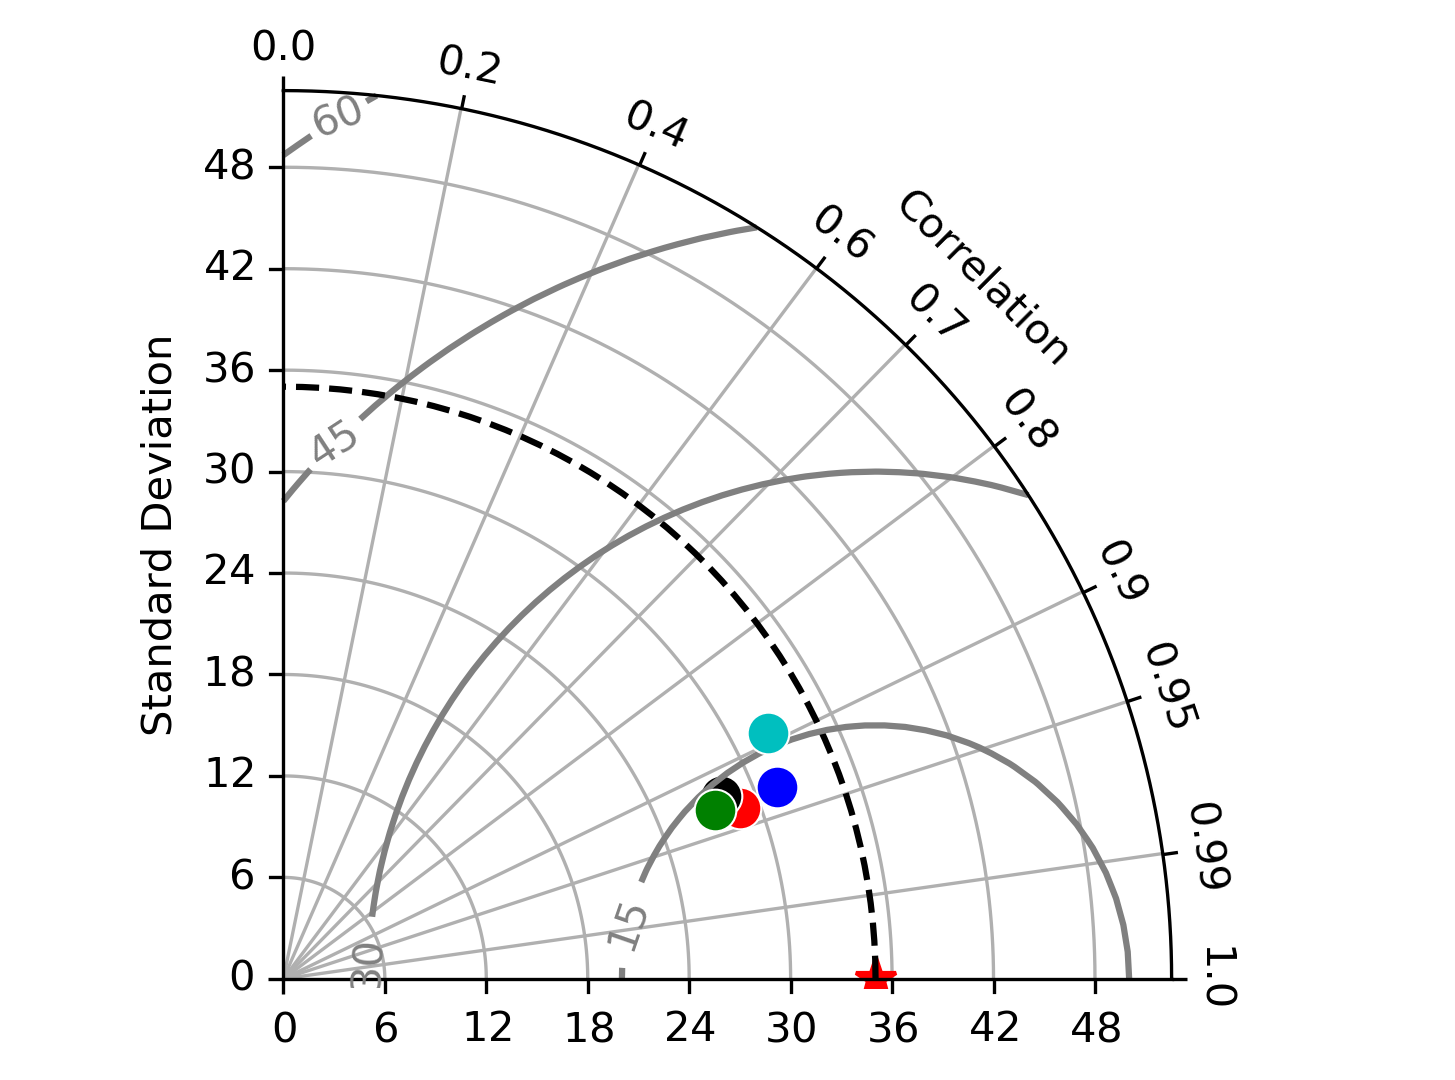

In [55]:

fig = plt.figure()

dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=False)
dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

# Remove bottom label
dia._ax.axis["left"].label.set_text("")

# Add label to left
dia._ax.axis["right"].toggle(label=True)
dia._ax.axis["right"].label.set_text("Standard Deviation")

# Add models to Taylor diagram
for i, (stddev, corrcoef, name, col, marker) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker=marker, ms=10, ls='',
                   mfc=col, mec='white', mew=0.5,
                   label=name)

# Add RMS contours, and label them
contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
plt.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

dia.add_grid()                                  # Add grid
dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward


plt.savefig(f'{dir_figs}/taylor_diagram_bats_latest.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)

In [56]:
for prod in df.columns:
    print(prod)
    print(df[prod].mean()-df['OBS'].mean())

somffn
-2.1362220070844273
carbo
4.37911162479935
lsce
-2.270152488217377
csir
0.17856892668061164
hpd
0.367692526752478
OBS
0.0


In [57]:
def rmse(prod):
    return np.sqrt(((df[prod]-df['OBS'])**2).mean())

for prod in df.columns:
    print(prod)
    print(rmse(prod))

somffn
14.283340742510182
carbo
16.478255934012626
lsce
13.965614403408182
csir
12.922237582154779
hpd
12.760981386751022
OBS
0.0
